# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [1]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [2]:
import itertools
from collections import Counter
from string import punctuation
from razdel import tokenize

## Датасет RT. Предварительная обработка

Загрузим датасет rt. Одновременно сделаем преобразование даты из строки

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [4]:
data_rt = pd.read_csv('../data/rt.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"')

In [5]:
# Проверим преобразование
data_rt.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors               float64
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [6]:
data_rt.shape

(106644, 16)

In [7]:
# Так выглядет датасет RT
data_rt.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-06-26 14:00:00,https://russian.rt.com/russia/news/644595-avto...,-,Россия,NaN,Эксперт прокомментировал ситуацию с возможным ...,"Как считает эксперт, россиянам не стоит пережи...",-,-,-,-,-,-,-,-,-
1,2019-06-26 19:56:00,https://russian.rt.com/sport/article/644740-nu...,-,Спорт,NaN,"Встреча Нурмагомедова с Макгрегором, восстанов...",«Конор может посетить поединок Хабиба с Порье»...,-,-,-,-,-,-,-,-,-
2,2019-06-26 14:52:00,https://russian.rt.com/russia/news/644619-puti...,-,Россия,NaN,Путин подарил Зюганову на юбилей материалы съе...,"Открывая заседание Госсовета в Кремле, Путин п...",-,-,-,-,-,-,-,-,-
3,2019-06-26 14:44:00,https://russian.rt.com/world/news/644618-parla...,-,Мир,NaN,"Парламентарии США, ФРГ и России проведут встре...",Об этом информируетnРИА Новостиnсо ссылкой на ...,-,-,-,-,-,-,-,-,-
4,2019-06-26 14:42:00,https://russian.rt.com/sport/news/644617-mok-a...,-,Спорт,NaN,МОК принял решение лишить признания AIBA,Решением 134-й сессии МОК в швейцарской Лозанн...,-,-,-,-,-,-,-,-,-


In [8]:
# Выясним в каким столбцах есть пустые данные
data_rt.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text            True
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [9]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_rt['text'].isnull().sum())
data_rt[data_rt['text'].isnull()].head()

Кол-во строк с значением NaN в столбце "Text" =  12


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
37474,2019-06-05 13:47:00,https://russian.rt.com/russia/video/638188-obr...,-,Россия,NaN,\n В Дагестане люди пытаются вручну...,NaN,-,-,-,-,-,-,-,-,-
38249,2017-12-11 19:32:00,https://russian.rt.com/sport/article/459073-ro...,-,Спорт,NaN,Не без труда: Россия в овертайме победила Южну...,NaN,-,-,-,-,-,-,-,-,-
43956,2017-12-08 01:29:00,https://russian.rt.com/world/article/457555-la...,-,Мир,NaN,"Будущее Сирии, перенос столицы Израиля и ситуа...",NaN,-,-,-,-,-,-,-,-,-
84132,2016-07-29 10:08:01,https://russian.rt.com/article/314450-dollar-p...,-,Россия,NaN,Доллар превысил 67 рублей,NaN,-,-,-,-,-,-,-,-,-
86097,2016-07-27 11:24:00,https://russian.rt.com/article/314142-sbornaya...,-,Спорт,NaN,Сборная России по тхэквондо в полном составе д...,NaN,-,-,-,-,-,-,-,-,-


In [10]:
#Удалим эти строки
data_rt.drop(data_rt[data_rt.text.isnull()].index, inplace=True)

In [11]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_rt['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


Посмотрим сколько элементов Nan в столбце авторов

In [12]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_rt['authors'].isnull().sum())

Кол-во строк с значением NaN в столбце "authors" =  106632


Как видим все значения авторов Nan. Можно не использовать данные столбец

Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [13]:
def analysis_columns(columns):
    for column in columns:
        if column not in ['url', 'date', 'topics', 'authors', 'title', 'text']:
            yield(print(str(column) + ':', data_rt[column].unique()))

In [14]:
data_columns = list(analysis_columns(data_rt.columns))

edition: ['-']
reposts_fb: ['-']
reposts_vk: ['-']
reposts_ok: ['-']
reposts_twi: ['-']
reposts_lj: ['-']
reposts_tg: ['-']
likes: ['-']
views: ['-']
comm_count: ['-']


Значений нет, можно удалять

In [15]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_rt.text.duplicated().sum())

Кол-во одинаковых текстов: 282


In [16]:
data_rt = data_rt.drop_duplicates(subset='text')

In [17]:
data_rt.shape

(106350, 16)

## EDA

### Анализ дат

In [18]:
print('Минимальная дата в датасете:', data_rt.date.min())
print('Максимальная дата в датасете:', data_rt.date.max())

Минимальная дата в датасете: 2014-06-16 18:36:02
Максимальная дата в датасете: 2019-08-02 14:10:00


#### Распределение количества новостей по месяцам

In [19]:
# Вынесем месяц и год новости в отдельные столбцы
data_rt['month'] = data_rt.date.apply(lambda x: x.month)
data_rt['year'] = data_rt.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_rt.groupby(['year', 'month']).text.nunique().reset_index()

In [20]:
df.head()

,year,month,text
0,2014,6,1
1,2014,9,396
2,2014,10,1036
3,2014,11,1389
4,2014,12,1657


In [21]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [22]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [23]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [24]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head()

,month_year,nunique_text
29,05-2019,8268
20,12-2017,8266
26,11-2018,8130
22,05-2018,8088
19,11-2017,7793


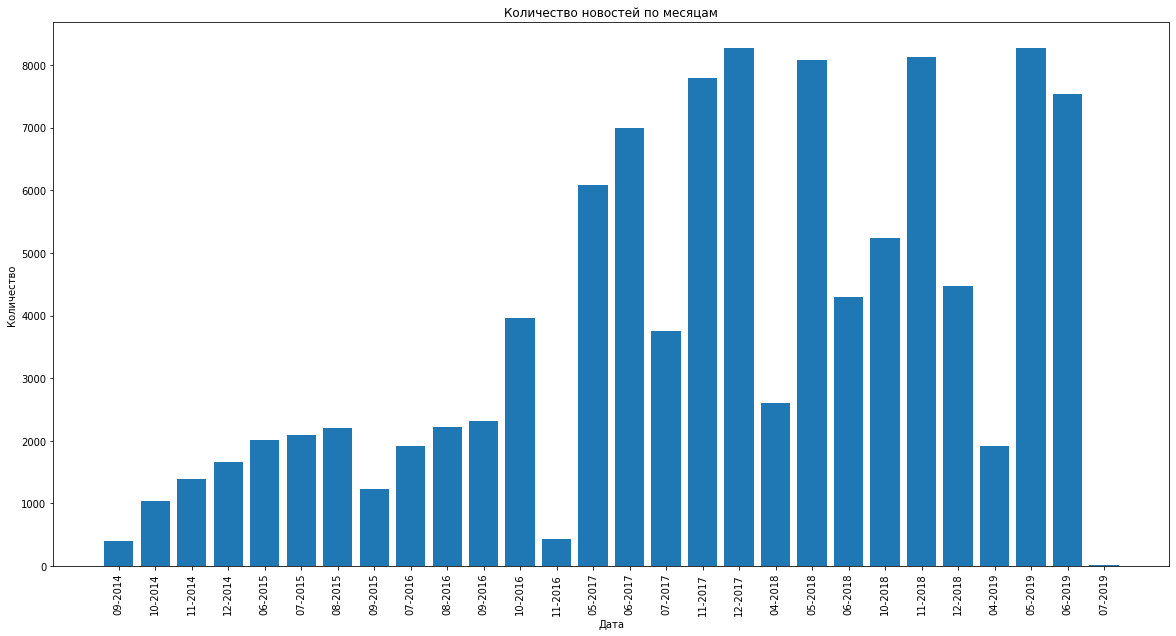

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')

ax.set_title('Количество новостей по месяцам')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
plt.show()

### Создание словаря для анализа

В данной части блокнота будет подготовлен словарь из всего множества слов во всем датасете. Для каждой новости будет выполнена токенизация. Затем будет собран словарь из всех токенов, очистка от знаков препинания, и после данных процедур создается два списка - один без удаления стоп-слов, второй с удалением.
Анализ проводится по частоте вхождений для каждого списка

In [26]:
def create_dictionary(text):
    for news in text:
        tokens = list(tokenize(news.lower()))
        yield([_.text for _ in tokens])

In [27]:
data_rt.text = list(create_dictionary(data_rt.text.values))

In [28]:
# Соберем словарь из новостей для последующего анализа, без объединения повторяющихся слов
dictionary = list(itertools.chain.from_iterable(data_rt.text.values))

In [280]:
# Соберем значки препинания, часть возьмем из готовой библиотеки, часть добавим свои

In [47]:
punctuation = list(punctuation)

In [48]:
punctuation += ['«','»','—','n','»,','».','nранее', 'nв', 'nпо', 'nтакже','u','n—', '...']

In [49]:
# Словарь без удаления стопслов
dictionary_with_stopwords = [item for item in dictionary if item not in punctuation]

In [32]:
stopwords_01 = open('../nlp/preprocessing/stopwords.txt', 'r', encoding='UTF-8')
stopwords_01 = stopwords_01.read().split('\n')
stopwords_02 = open('../nlp/preprocessing/stopwords_02.txt', 'r', encoding='UTF-8')
stopwords_02 = stopwords_02.read().split('\n')

In [33]:
stopwords = stopwords_01 + stopwords_02

In [50]:
# Словарь после удаления стопслов
dictionary_without_stopwords = [item for item in dictionary_with_stopwords if item not in stopwords]

### Аналитика по словам

#### 20 самых популярных слов без удаления стопслов

In [51]:
Counter(dictionary_with_stopwords).most_common(20)

[('в', 656240),
 ('и', 338868),
 ('на', 275793),
 ('что', 230555),
 ('с', 171235),
 ('по', 162753),
 ('не', 150147),
 ('ранее', 73700),
 ('о', 63977),
 ('как', 63264),
 ('он', 62065),
 ('для', 59697),
 ('это', 59209),
 ('к', 56651),
 ('россии', 56152),
 ('из', 55134),
 ('за', 54935),
 ('а', 52405),
 ('также', 49500),
 ('его', 46680)]

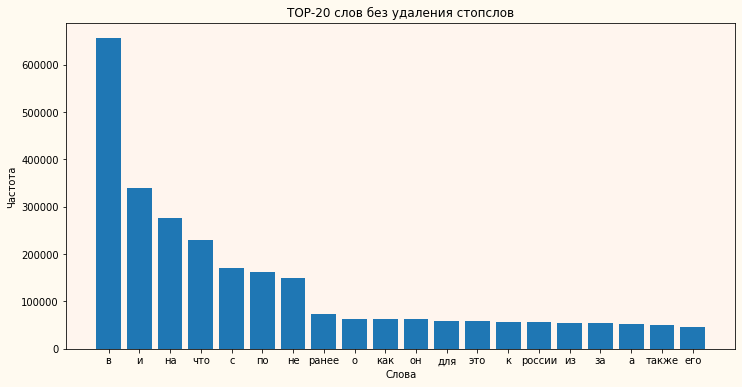

In [52]:
x = dict(Counter(dictionary_with_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_with_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

#### 20 самых популярных слов после удаления стопслов 

In [53]:
Counter(dictionary_without_stopwords).most_common(20)

[('россии', 56152),
 ('сша', 38624),
 ('заявил', 30196),
 ('сообщалось', 23039),
 ('словам', 22485),
 ('новости', 21847),
 ('отметил', 21257),
 ('риа', 21051),
 ('сообщает', 18245),
 ('отмечается', 16483),
 ('украины', 16192),
 ('1', 16051),
 ('2', 16036),
 ('rt', 15349),
 ('слова', 15295),
 ('приводит', 15144),
 ('страны', 13892),
 ('цитирует', 13827),
 ('мая', 13049),
 ('решение', 12689)]

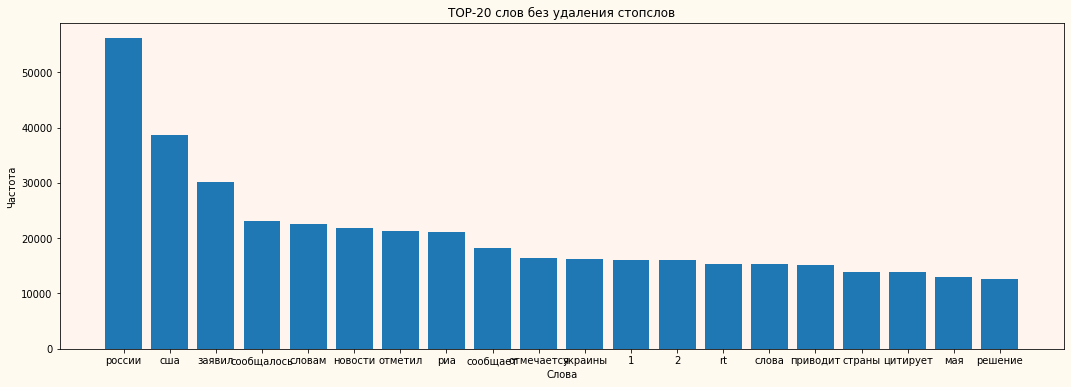

In [54]:
x = dict(Counter(dictionary_without_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_without_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

### Рубрики RT

In [55]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_rt.topics.unique().shape)
data_rt['topics'].unique()

Количество рубрик =  (10,)


array(['Россия', 'Спорт', 'Мир', 'Без политики', 'Новости партнёров',
       'Бывший СССР', 'Экономика', 'Наука', 'Мероприятия RT',
       'Пресс-релизы'], dtype=object)

Все рубрики, с количеством новостей в каждой группе

In [56]:
data_rt.groupby('topics')['topics'].count().sort_values(ascending=False)

topics
Россия               32864
Спорт                26678
Мир                  26369
Бывший СССР          10074
Без политики          4437
Экономика             4316
Наука                 1493
Пресс-релизы            92
Новости партнёров       14
Мероприятия RT          13
Name: topics, dtype: int64